# Cross-Lingual Self-RAG with Multi-Model Support

## 1. Installation and Imports

In [ ]:
# Install required packages
!pip install -q transformers torch wikipedia-api googletrans==4.0.0-rc1 sentence-transformers
!pip install -q numpy pandas tqdm colorama huggingface-hub accelerate bitsandbytes

In [ ]:
import os
import json
import time
import warnings
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass, asdict
from enum import Enum
import re

import numpy as np
import pandas as pd
from tqdm import tqdm
from colorama import Fore, Style, init

# Translation and NLP
from googletrans import Translator
import wikipediaapi
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)
import torch
from huggingface_hub import login

# Initialize colorama for colored output
init(autoreset=True)
warnings.filterwarnings('ignore')

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\nAll packages imported successfully!")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB

All packages imported successfully!


## 2. Hugging Face Authentication

In [ ]:
# Login to Hugging Face
try:
    login(os.getenv("HF_TOKEN"))
    print("✅ Successfully logged in to Hugging Face!")
except Exception as e:
    print(f"⚠️ Warning: Could not login to Hugging Face: {e}")
    print("You may need to authenticate manually or some models might not be accessible.")

✅ Successfully logged in to Hugging Face!


## 3. Configuration and Data Classes

In [ ]:
# Configuration
@dataclass
class Config:
    """Configuration for the Cross-Lingual Self-RAG system with Multi-Model Support"""
    # Language settings
    supported_languages: List[str] = None
    language_codes: Dict[str, str] = None

    # Retrieval settings
    wikipedia_top_k: int = 3
    max_passage_length: int = 500

    # Model settings - will be set dynamically based on input
    llm_model: str = "google/gemma-2b-it"  # Default, will be overridden
    model_type: str = "gemma"  # Default, will be overridden
    llm_temperature: float = 0.1
    llm_max_new_tokens: int = 512  # Maximum new tokens to generate
    llm_top_p: float = 0.95
    llm_top_k: int = 50
    llm_repetition_penalty: float = 1.1

    # Memory optimization settings
    load_in_8bit: bool = False  # Set to True if you have memory constraints
    load_in_4bit: bool = False  # Even more memory efficient
    device_map: str = "auto"  # Automatically map model to available devices
    torch_dtype: str = "float16"  # Use float16 for memory efficiency

    # Output settings
    verbose: bool = False
    save_intermediate: bool = True

    def __post_init__(self):
        self.supported_languages = ['tamil', 'hindi', 'kannada', 'marathi', 'english']
        self.language_codes = {
            'tamil': 'ta',
            'hindi': 'hi',
            'kannada': 'kn',
            'marathi': 'mr',
            'english': 'en'
        }

# Data classes for structured outputs
class SupportJudgment(Enum):
    SUPPORTED = "supported"
    PARTIALLY_SUPPORTED = "partially_supported"
    NOT_SUPPORTED = "not_supported"

@dataclass
class CritiqueResult:
    judgment: SupportJudgment
    rationale: str
    revised_answer: str
    confidence: float

@dataclass
class SelfRAGOutput:
    """Final output structure as specified in Step 9"""
    final_answer_indic: str  # Final answer in Indic language
    judgment_label: str  # supported / partial / not supported
    support_confidence: float  # Confidence score [0, 1]
    english_rationale: str  # Rationale for auditability

    # Additional fields for debugging
    initial_answer: str = None
    retrieved_context: str = None
    regenerated_answer: str = None
    english_answer: str = None

## 4. Wikipedia Retrieval Module

In [ ]:
import requests
import html

class WikipediaRetriever:
    """On-the-fly Wikipedia retrieval via MediaWiki API (multilingual)"""

    def __init__(self, config):
        self.config = config

    def resolve_language_key(self, language: str) -> str:
        language = language.strip().lower()
        if language in self.config.language_codes:
            return language
        for lang_key in self.config.language_codes:
            if lang_key.lower() == language:
                return lang_key
        return language

    def normalize_token(self, token: str, language: str) -> str:
        return re.sub(r"[^\w\u0B80-\u0BFF\u0900-\u097F\u0C80-\u0CFF\u0964-\u0965]", "", token).strip()

    def extract_keywords(self, question: str, language: str) -> List[str]:
        stop_patterns = {
            "tamil": ["என்ன", "என்று", "எப்படி", "ஏன்", "எங்கே", "எப்போது", "யார்"],
            "hindi": ["क्या", "कब", "कहाँ", "कैसे", "क्यों", "कौन", "है", "हैं", "के", "में", "का"],
            "kannada": ["ಏನು", "ಯಾವಾಗ", "ಎಲ್ಲಿ", "ಹೇಗೆ", "ಏಕೆ", "ಯಾರು"],
            "marathi": ["काय", "कधी", "कुठे", "कसे", "का", "कोण"],
            "english": ["what", "when", "where", "how", "why", "who", "is", "are", "the", "a", "an", "of"]
        }

        raw_words = question.split()
        normalized_words = [self.normalize_token(w, language) for w in raw_words]

        stop_words = stop_patterns.get(language, [])
        stop_lower = {s.lower() for s in stop_words}

        keywords = [w for w in normalized_words if w and w.lower() not in stop_lower]
        return keywords[:5]

    def mediawiki_search(self, language: str, query: str, limit: int) -> List[Dict]:
        code = self.config.language_codes.get(language)
        if not code:
            return []

        url = f"https://{code}.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "list": "search",
            "srsearch": query,
            "srlimit": limit,
            "format": "json",
            "utf8": 1,
        }

        r = requests.get(
            url, params=params, timeout=8,
            headers={"User-Agent": "CrossLingualRAG/1.0"}
        )
        r.raise_for_status()
        data = r.json()
        return data.get("query", {}).get("search", [])

    def fetch_extracts(self, language: str, pageids: List[int], chars: int) -> Dict[int, str]:
        code = self.config.language_codes.get(language)
        if not code or not pageids:
            return {}

        url = f"https://{code}.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "prop": "extracts|pageprops",
            "exintro": 1,
            "explaintext": 1,
            "exchars": chars,
            "pageids": "|".join(str(pid) for pid in pageids),
            "format": "json",
            "utf8": 1,
        }

        r = requests.get(
            url, params=params, timeout=8,
            headers={"User-Agent": "CrossLingualRAG/1.0"}
        )
        r.raise_for_status()

        pages = r.json().get("query", {}).get("pages", {})
        out: Dict[int, str] = {}

        for pid_str, pdata in pages.items():
            if isinstance(pdata, dict) and pdata.get("pageprops", {}).get("disambiguation") is not None:
                continue
            try:
                out[int(pid_str)] = pdata.get("extract", "") or ""
            except Exception:
                pass
        return out

    def build_query_variants(self, question: str, language: str) -> List[str]:
        q_full = re.sub(
            r"\s+", " ",
            re.sub(r"[^\w\s\u0B80-\u0BFF\u0900-\u097F\u0C80-\u0CFF]", " ", question)
        ).strip()

        keywords = self.extract_keywords(question, language)

        variants: List[str] = []
        if q_full:
            variants.append(q_full)
        if keywords:
            variants.append(" ".join(keywords))

        for i in range(len(keywords) - 1):
            variants.append(keywords[i] + " " + keywords[i + 1])

        variants.extend(keywords)

        seen = set()
        uniq = []
        for v in variants:
            k = v.strip().lower()
            if v.strip() and k not in seen:
                seen.add(k)
                uniq.append(v.strip())

        return uniq[:10]

    def search_wikipedia(self, question: str, language: str, top_k: Optional[int] = None) -> List[str]:
        if top_k is None:
            top_k = self.config.wikipedia_top_k

        top_k = max(1, int(top_k))

        language = self.resolve_language_key(language)
        if language not in self.config.language_codes:
            if getattr(self.config, "verbose", False):
                print(f"[WikipediaRetriever] Unknown language key: {language}. "
                      f"Available: {list(self.config.language_codes.keys())}")
            return []

        variants = self.build_query_variants(question, language)
        if getattr(self.config, "verbose", False):
            print(f"[WikipediaRetriever] Query variants: {variants}")

        candidates = {}
        try:
            for q in variants:
                hits = self.mediawiki_search(language, q, limit=max(10, top_k * 3))
                for h in hits:
                    pid = int(h.get("pageid", 0))
                    if not pid or pid in candidates:
                        continue
                    title = h.get("title", "") or ""
                    snippet = h.get("snippet", "") or ""
                    snippet = html.unescape(re.sub(r"<[^>]+>", "", snippet))
                    candidates[pid] = (title, snippet)

                if len(candidates) >= top_k * 10:
                    break
        except Exception as e:
            if getattr(self.config, "verbose", False):
                print(f"[WikipediaRetriever] Search error: {e}")
            return []

        if not candidates:
            return []

        pid_list = list(candidates.keys())[:max(30, top_k * 10)]
        try:
            extracts = self.fetch_extracts(language, pid_list, chars=self.config.max_passage_length)
        except Exception as e:
            if getattr(self.config, "verbose", False):
                print(f"[WikipediaRetriever] Extract error: {e}")
            return []

        q_tokens = re.findall(r"\w+", question.lower())
        q_tokens = {t for t in q_tokens if len(t) >= 3}

        scored = []
        for pid in pid_list:
            title, snippet = candidates[pid]
            extract = extracts.get(pid, "") or ""
            title_l = title.lower()
            snippet_l = snippet.lower()
            extract_l = extract.lower()

            title_hits = sum(1 for t in q_tokens if t in title_l)
            snippet_hits = sum(1 for t in q_tokens if t in snippet_l)
            extract_hits = sum(1 for t in q_tokens if t in extract_l)

            score = 3 * title_hits + 2 * snippet_hits + 1 * extract_hits
            scored.append((score, pid, title, extract))

        scored.sort(reverse=True, key=lambda x: x[0])

        passages = []
        for score, pid, title, extract in scored[:top_k]:
            extract = (extract or "").strip()
            if extract:
                passages.append(f"[Source: {title}]\n{extract[:self.config.max_passage_length]}")

        return passages

    def retrieve(self, question: str, language: str, gold_context: Optional[str] = None) -> str:
        contexts = []

        if gold_context:
            contexts.append(f"[Gold Context]\n{gold_context}")

        wiki_passages = self.search_wikipedia(question, language, top_k=self.config.wikipedia_top_k)
        contexts.extend(wiki_passages)

        combined = "\n\n".join(contexts)
        return combined if combined else "No relevant context found."

## 5. Translation Module

In [ ]:
class TranslationModule:
    """Module for cross-lingual translation"""

    def __init__(self, config: Config):
        self.config = config
        self.translator = Translator()

    def translate_to_english(self, text: str, source_lang: str) -> str:
        """Translate text to English"""
        if not text or source_lang == 'english':
            return text

        try:
            lang_code = self.config.language_codes.get(source_lang, source_lang)
            result = self.translator.translate(text, src=lang_code, dest='en')
            return result.text
        except Exception as e:
            print(f"Translation error: {e}")
            return text

    def translate_from_english(self, text: str, target_lang: str) -> str:
        """Translate text from English to target language"""
        if not text or target_lang == 'english':
            return text

        try:
            lang_code = self.config.language_codes.get(target_lang, target_lang)
            result = self.translator.translate(text, src='en', dest=lang_code)
            return result.text
        except Exception as e:
            print(f"Translation error: {e}")
            return text

## 6. Multi-Model LLM Module (Gemma, Sarvam, Aya)

In [ ]:
import os, shelve, hashlib

def _cache_key(question: str, language: str) -> str:
    # stable key even if question is long
    h = hashlib.sha256(f"{language}||{question}".encode("utf-8")).hexdigest()
    return h

class RetrievalCache:
    def __init__(self, cache_path: str):
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        self.cache_path = cache_path

    def get(self, question: str, language: str):
        key = _cache_key(question, language)
        with shelve.open(self.cache_path) as db:
            return db.get(key, None)

    def set(self, question: str, language: str, context: str):
        key = _cache_key(question, language)
        with shelve.open(self.cache_path) as db:
            db[key] = context


In [ ]:
class MultiModelSelfRAG:
    """Multi-model Self-RAG module supporting Gemma, Sarvam, and Aya models"""

    def __init__(self, config: Config):
        self.config = config
        self.model = None
        self.tokenizer = None
        self.current_model_type = None
        self._load_model()

    def _load_model(self):
        """Load the appropriate model based on config.model_type"""
        model_type = self.config.model_type.lower()

        # Model mapping
        model_mapping = {
            "gemma": "google/gemma-2b-it",
            "sarvam": "sarvamai/sarvam-1",
            "aya": "CohereLabs/aya-101"
        }

        if model_type not in model_mapping:
            print(f"Warning: Unknown model type {model_type}, using gemma as default")
            model_type = "gemma"

        self.config.llm_model = model_mapping[model_type]
        self.current_model_type = model_type

        print(f"Loading {model_type.upper()} model: {self.config.llm_model}")

        # Quantization configuration
        bnb_config = None
        if self.config.load_in_4bit:
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4"
            )
        elif self.config.load_in_8bit:
            bnb_config = BitsAndBytesConfig(
                load_in_8bit=True,
                bnb_8bit_compute_dtype=torch.float16
            )

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.config.llm_model,
            use_auth_token=True
        )

        # Set padding token if not present
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Load model with appropriate dtype and device mapping
        torch_dtype = torch.float16 if self.config.torch_dtype == "float16" else torch.float32

        self.model = AutoModelForCausalLM.from_pretrained(
            self.config.llm_model,
            torch_dtype=torch_dtype,
            device_map=self.config.device_map,
            quantization_config=bnb_config,
            use_auth_token=True,
            trust_remote_code=True
        )

        print(f"{Fore.GREEN}✓ {model_type.upper()} Model loaded successfully!{Style.RESET_ALL}")

        # Print model info
        total_params = sum(p.numel() for p in self.model.parameters())
        print(f"Model parameters: {total_params / 1e9:.2f}B")

    def _format_prompt(self, instruction: str, context: str = "") -> str:
        """Format prompt based on model type"""
        if self.current_model_type == "gemma":
            # Gemma-IT uses a specific format for instructions
            if context:
                prompt = f"<start_of_turn>user\n{context}\n\n{instruction}<end_of_turn>\n<start_of_turn>model\n"
            else:
                prompt = f"<start_of_turn>user\n{instruction}<end_of_turn>\n<start_of_turn>model\n"
        elif self.current_model_type == "sarvam":
            # Sarvam model format - adjust based on actual model requirements
            if context:
                prompt = f"### Context:\n{context}\n\n### Instruction:\n{instruction}\n\n### Response:\n"
            else:
                prompt = f"### Instruction:\n{instruction}\n\n### Response:\n"
        elif self.current_model_type == "aya":
            # Aya model format - adjust based on actual model requirements
            if context:
                prompt = f"Context: {context}\n\nQuestion: {instruction}\n\nAnswer:"
            else:
                prompt = f"Question: {instruction}\n\nAnswer:"
        else:
            # Default format
            if context:
                prompt = f"{context}\n\n{instruction}"
            else:
                prompt = instruction

        return prompt

    def _generate_response(self, prompt: str) -> str:
        """Generate response using the loaded model"""
        try:
            # Tokenize input
            inputs = self.tokenizer(
                prompt,
                return_tensors="pt",
                truncation=True,
                max_length=2048,
                padding=True
            )

            # Get the model's device
            model_device = next(self.model.parameters()).device

            # Move ALL inputs to the same device as the model
            inputs = {k: v.to(model_device) for k, v in inputs.items()}

            # Ensure attention_mask is present
            if 'attention_mask' not in inputs:
                inputs['attention_mask'] = torch.ones_like(inputs['input_ids'])

            # Generate response
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=self.config.llm_max_new_tokens,
                    temperature=self.config.llm_temperature,
                    top_p=self.config.llm_top_p,
                    top_k=self.config.llm_top_k,
                    repetition_penalty=self.config.llm_repetition_penalty,
                    do_sample=True if self.config.llm_temperature > 0 else False,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )

            # Decode response
            response = self.tokenizer.decode(
                outputs[0][inputs['input_ids'].shape[1]:],
                skip_special_tokens=True
            )

            return response.strip()

        except Exception as e:
            print(f"Generation error: {e}")
            return ""

    def regenerate_answer(self, question: str, initial_answer: str, context: str, language: str) -> str:
        """Step 3: Self-RAG Regeneration in source language"""
        instruction = f"""You are a helpful assistant that answers questions based strictly on provided context.

Question: {question}

Initial Answer: {initial_answer}

Task: Re-answer the question using ONLY the information present in the context below.
If Gold Context is present, slightly prefer it over Wikipedia-based context when answering.
When using Wikipedia-based context, first compare it with the question and use it only if the context clearly supports it.
If the required information is missing or unclear in the context, explicitly state that you cannot answer due to lack of context.
Be factual and concise. Answer in {language}.

Your answer:"""

        formatted_prompt = self._format_prompt(instruction, context)
        regenerated = self._generate_response(formatted_prompt)

        if self.config.verbose:
            print(f"{Fore.CYAN}Regenerated answer in {language} using {self.current_model_type.upper()}{Style.RESET_ALL}")

        return regenerated

    def critique_answer(self, question_en: str, context_en: str, answer_en: str):
        """
        Cross-lingual critique.
        Returns: (confidence: float, revised_answer: str)
        """

        instruction = f"""You are a factual verification and revision system.

    Question:
    {question_en}

    Current Answer:
    {answer_en}

    Context:
    {context_en}

    Return only:
    A revised answer grounded ONLY in the Context, OR a clear refusal saying, I can't answer due to missing context.

    Rules:
    - Use ONLY information explicitly stated in the Context.
    - Do NOT output JSON, markdown, labels, or explanations.
    """

        formatted_prompt = self._format_prompt(instruction, context="")
        response = (self._generate_response(formatted_prompt) or "").strip()

        return response


    def cleanup(self):
        """Clean up model from memory"""
        if self.model is not None:
            del self.model
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
        self.model = None
        self.tokenizer = None

    def regenerate_answer_batch(
        self,
        questions,
        initial_answers,
        contexts,
        language,
        batch_size=8
    ):
        """
        Batched version of regenerate_answer for fast GPU inference
        """

        assert len(questions) == len(initial_answers) == len(contexts)

        results = []

        # REQUIRED for generation
        self.tokenizer.padding_side = "left"
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        for i in range(0, len(questions), batch_size):
            batch_q = questions[i:i + batch_size]
            batch_a = initial_answers[i:i + batch_size]
            batch_c = contexts[i:i + batch_size]

            prompts = []

            for q, a, c in zip(batch_q, batch_a, batch_c):
                instruction = f"""You are a helpful assistant that answers questions based strictly on provided context.

Question: {q}

Initial Answer: {a}

Task: Re-answer the question using ONLY the information present in the context below.
If Gold Context is present, try to prefer it over Wikipedia-based context when answering.
If the required information is missing or unclear, explicitly say so. Don't give one word answers.
Answer in {language}.

Your answer:"""

                prompts.append(self._format_prompt(instruction, c))

            inputs = self.tokenizer(
                prompts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=2048
            )

            model_device = next(self.model.parameters()).device
            inputs = {k: v.to(model_device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=self.config.llm_max_new_tokens,
                    temperature=self.config.llm_temperature,
                    top_p=self.config.llm_top_p,
                    top_k=self.config.llm_top_k,
                    repetition_penalty=self.config.llm_repetition_penalty,
                    do_sample=self.config.llm_temperature > 0,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )

            decoded = self.tokenizer.batch_decode(
                outputs[:, inputs["input_ids"].shape[1]:],
                skip_special_tokens=True
            )

            results.extend([x.strip() for x in decoded])

        return results


## 7. Main Cross-Lingual Self-RAG Pipeline

In [ ]:
class CrossLingualSelfRAG:
    """Main pipeline integrating all components with Multi-Model Support"""

    def __init__(self, config: Config = None):
        self.config = config or Config()

        # Initialize modules
        print("Initializing Cross-Lingual Self-RAG modules...")
        print("="*60)

        print("1. Initializing Wikipedia Retriever...")
        self.retriever = WikipediaRetriever(self.config)

        print("\n2. Initializing Translation Module...")
        self.translator = TranslationModule(self.config)

        print(f"\n3. Initializing {self.config.model_type.upper()} Model...")
        self.llm = MultiModelSelfRAG(self.config)

        print("="*60)
        print(f"{Fore.GREEN}✓ All modules initialized successfully!{Style.RESET_ALL}\n")

    def process(self,
                question_L: str,
                answer_L: str,
                language_L: str,
                context_L: Optional[str] = None) -> SelfRAGOutput:
        """
        Main processing pipeline

        Args:
            question_L: Question in Indic language
            answer_L: Initial answer in Indic language
            language_L: Source language (tamil/hindi/kannada/marathi)
            context_L: Optional gold context in Indic language

        Returns:
            SelfRAGOutput with all results
        """

        print(f"\n{Fore.YELLOW}=== Processing Query in {language_L.upper()} ==={Style.RESET_ALL}")

        # Step 2: On-the-fly Wikipedia Retrieval
        retrieved_context = self.retriever.retrieve(question_L, language_L, context_L)

        # Step 3: Self-RAG Regeneration in source language
        regenerated_answer_L = self.llm.regenerate_answer(
            question_L, answer_L, retrieved_context, language_L
        )

        # Step 4: Cross-lingual projection to English
        question_EN = self.translator.translate_to_english(question_L, language_L)
        context_EN = self.translator.translate_to_english(retrieved_context, language_L)
        regenerated_answer_EN = self.translator.translate_to_english(regenerated_answer_L, language_L)

        # Step 5: Cross-lingual self-critique
        revised_answer_EN = self.llm.critique_answer(question_EN, context_EN, regenerated_answer_EN)

        # Step 7: Back-projection to source language
        final_answer_L = self.translator.translate_from_english(
            revised_answer_EN, language_L
        )

        # Step 8: Final output structure
        output = SelfRAGOutput(
            final_answer_indic=final_answer_L,
            support_confidence=1,
            initial_answer=answer_L,
            retrieved_context=retrieved_context[:500],
            regenerated_answer=regenerated_answer_L,
            english_answer=revised_answer_EN,
        )


        print(f"{Fore.GREEN}✓ Processing complete{Style.RESET_ALL}")
        return output

    def cleanup(self):
        """Clean up all modules"""
        print("\nCleaning up resources...")
        self.llm.cleanup()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        print("✓ Cleanup complete")

## 8. CSV Processing with Dynamic Model Selection

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

def detect_model_and_language_from_path(input_csv_path):
    """
    Detect model type and language from the CSV path.
    Expected path structure: .../Results/Vanilla/{model}/{model}_results_{language}.csv
    """
    path_parts = input_csv_path.replace("\\", "/").split("/")

    # Try to find model name from path
    model_type = "gemma"  # default
    language = "tamil"  # default

    # Look for model folder name
    if "sarvam" in input_csv_path.lower():
        model_type = "sarvam"
    elif "aya" in input_csv_path.lower():
        model_type = "aya"
    elif "gemma" in input_csv_path.lower():
        model_type = "gemma"

    # Try to extract language from filename
    filename = os.path.basename(input_csv_path).lower()
    if "ta" in filename:
        language = "tamil"
    elif "en" in filename:
        language = "english"
    elif "hi" in filename:
        language = "hindi"
    elif "ka" in filename:
        language = "kannada"
    elif "ma" in filename:
        language = "marathi"

    return model_type, language

# def run_selfrag_on_csv(input_csv_path, model_type=None, language=None):
#     """
#     Run Self-RAG on a CSV file with dynamic model selection.

#     Args:
#         input_csv_path: path to a CSV under Results/Vanilla/...
#         model_type: 'gemma', 'sarvam', or 'aya' (if None, will auto-detect)
#         language: language of the content (if None, will auto-detect)
#     """

#     # Auto-detect model and language if not provided
#     if model_type is None or language is None:
#         detected_model, detected_language = detect_model_and_language_from_path(input_csv_path)
#         if model_type is None:
#             model_type = detected_model
#         if language is None:
#             language = detected_language

#     print(f"\n" + "="*60)
#     print(f"Processing: {os.path.basename(input_csv_path)}")
#     print(f"Model: {model_type.upper()}")
#     print(f"Language: {language.upper()}")
#     print("="*60 + "\n")

#     # Create config with the appropriate model
#     config = Config()
#     config.model_type = model_type

#     # Adjust settings based on model size if needed
#     if model_type == "aya":
#         # Aya is typically larger, might need more memory optimization
#         config.load_in_4bit = True  # Enable 4-bit quantization for larger models

#     # Initialize pipeline with the selected model
#     pipeline = CrossLingualSelfRAG(config)

#     # Load CSV
#     df = pd.read_csv(input_csv_path)
#     # DEBUG: run only first 20 rows
#     # df = df.head(8)

#     required_cols = {"Question", "model_response"}
#     missing = required_cols - set(df.columns)
#     if missing:
#         raise ValueError(f"Missing required columns: {missing}")

#     # Run self-rag
#     results = []

#     BATCH_SIZE = 8  # Safe for Gemma-2B / Sarvam-1 on T4

#     questions = df["Question"].tolist()
#     initial_answers = df["model_response"].tolist()

#     # Step 2: retrieve contexts (still row-wise, cheap)
#     contexts = []
#     for q in tqdm(questions, desc="Retrieving Wikipedia"):
#         contexts.append(pipeline.retriever.retrieve(q, language))
#     print("✅ Retrieval done. Starting BATCHED regeneration...")

#     # Step 3: BATCHED regeneration (THIS is the big win)
#     regenerated_answers = pipeline.llm.regenerate_answer_batch(
#         questions,
#         initial_answers,
#         contexts,
#         language,
#         batch_size=BATCH_SIZE
#     )
#     print("✅ Regeneration done. Starting critique/projection...")
#     print(regenerated_answers)

#     results = []

#     # Remaining steps (translation + critique) stay unchanged
#     for q, ctx, regen in tqdm(
#         zip(questions, contexts, regenerated_answers),
#         total=len(questions),
#         desc="Critique + Projection"
#     ):
#         # q_en = pipeline.translator.translate_to_english(q, language)
#         # ctx_en = pipeline.translator.translate_to_english(ctx, language)
#         # ans_en = pipeline.translator.translate_to_english(regen, language)

#         # revised_answer_en = pipeline.llm.critique_answer(
#         #     q_en, ctx_en, ans_en
#         # )

#         # final_L = pipeline.translator.translate_from_english(
#         #     revised_answer_en, language
#         # )

#         results.append({
#             "final_answer": regen
#         })


#     # Add results to dataframe
#     for key in results[0].keys():
#         df[f"selfrag_{key}"] = [r[key] for r in results]

#     # Generate output path
#     output_csv_path = input_csv_path.replace(
#         os.sep + "Vanilla" + os.sep,
#         os.sep + "selfrag" + os.sep
#     )

#     os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

#     # Save results
#     df.to_csv(output_csv_path, index=False)
#     print(f"\n✅ Results saved to: {output_csv_path}")

#     # Cleanup
#     pipeline.cleanup()

#     return output_csv_path

def run_selfrag_on_csv(
    input_csv_path,
    model_type=None,
    language=None,
    retrieval_cache_path="/content/drive/MyDrive/Project/wikipedia_retrieval_cache.db",
    shared_retrieval_pipeline=None,   # optional: reuse one pipeline for retrieval
):
    # Auto-detect
    if model_type is None or language is None:
        detected_model, detected_language = detect_model_and_language_from_path(input_csv_path)
        model_type = detected_model if model_type is None else model_type
        language = detected_language if language is None else language

    print(f"\n" + "="*60)
    print(f"Processing: {os.path.basename(input_csv_path)}")
    print(f"Model: {model_type.upper()}")
    print(f"Language: {language.upper()}")
    print("="*60 + "\n")

    # Build model-specific pipeline (for regeneration)
    config = Config()
    config.model_type = model_type
    if model_type == "aya":
        config.load_in_4bit = True

    pipeline = CrossLingualSelfRAG(config)

    df = pd.read_csv(input_csv_path)

    required_cols = {"Question", "model_response"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    questions = df["Question"].tolist()
    initial_answers = df["model_response"].tolist()

    # Use cache
    cache = RetrievalCache(retrieval_cache_path)

    # Use a shared pipeline for retrieval if provided (so you don't instantiate twice)
    retrieval_pipeline = shared_retrieval_pipeline if shared_retrieval_pipeline is not None else pipeline

    contexts = []
    misses = 0
    for q in tqdm(questions, desc="Retrieving Wikipedia (cached)"):
        cached_ctx = cache.get(q, language)
        if cached_ctx is None:
            ctx = retrieval_pipeline.retriever.retrieve(q, language)
            cache.set(q, language, ctx)
            misses += 1
        else:
            ctx = cached_ctx
        contexts.append(ctx)

    print(f"✅ Retrieval done. Cache misses: {misses}/{len(questions)}. Starting BATCHED regeneration...")

    BATCH_SIZE = 8
    regenerated_answers = pipeline.llm.regenerate_answer_batch(
        questions,
        initial_answers,
        contexts,
        language,
        batch_size=BATCH_SIZE
    )

    results = [{"final_answer": regen} for regen in regenerated_answers]

    for key in results[0].keys():
        df[f"selfrag_{key}"] = [r[key] for r in results]

    output_csv_path = input_csv_path.replace(
        os.sep + "Vanilla" + os.sep,
        os.sep + "selfrag" + os.sep
    )
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    df.to_csv(output_csv_path, index=False)
    print(f"\n✅ Results saved to: {output_csv_path}")

    pipeline.cleanup()
    return output_csv_path

## Batching

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
  # Example 1: Process a single CSV file (auto-detect model and language)
input_csv = "/content/drive/MyDrive/Project/Dataset/IndicQuest/Results/Vanilla/sarvam/sarvam_results_en.csv"
output_csv = run_selfrag_on_csv(input_csv)
print("Saved to:", output_csv)


Processing: sarvam_results_en.csv
Model: GEMMA
Language: ENGLISH

Initializing Cross-Lingual Self-RAG modules...
1. Initializing Wikipedia Retriever...

2. Initializing Translation Module...

3. Initializing GEMMA Model...
Loading GEMMA model: google/gemma-2b-it


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ GEMMA Model loaded successfully!
Model parameters: 2.51B
✓ All modules initialized successfully!



Retrieving Wikipedia (cached): 100%|██████████| 200/200 [00:02<00:00, 96.58it/s]


✅ Retrieval done. Cache misses: 0/200. Starting BATCHED regeneration...

✅ Results saved to: /content/drive/MyDrive/Project/Dataset/IndicQuest/Results/selfrag/sarvam/sarvam_results_en.csv

Cleaning up resources...
✓ Cleanup complete
Saved to: /content/drive/MyDrive/Project/Dataset/IndicQuest/Results/selfrag/sarvam/sarvam_results_en.csv


In [ ]:
input_csv = "/content/drive/MyDrive/Project/Dataset/IndicQuest/Results/Vanilla/gemma/gemma_results_en.csv"
output_csv = run_selfrag_on_csv(input_csv)
print("Saved to:", output_csv)


Processing: gemma_results_en.csv
Model: GEMMA
Language: ENGLISH

Initializing Cross-Lingual Self-RAG modules...
1. Initializing Wikipedia Retriever...

2. Initializing Translation Module...

3. Initializing GEMMA Model...
Loading GEMMA model: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ GEMMA Model loaded successfully!
Model parameters: 2.51B
✓ All modules initialized successfully!



Retrieving Wikipedia (cached): 100%|██████████| 200/200 [00:01<00:00, 116.10it/s]


✅ Retrieval done. Cache misses: 0/200. Starting BATCHED regeneration...

✅ Results saved to: /content/drive/MyDrive/Project/Dataset/IndicQuest/Results/selfrag/gemma/gemma_results_en.csv

Cleaning up resources...
✓ Cleanup complete
Saved to: /content/drive/MyDrive/Project/Dataset/IndicQuest/Results/selfrag/gemma/gemma_results_en.csv


## 11. Example Usage

In [ ]:
# Example 1: Process a single CSV file (auto-detect model and language)
input_csv = "/content/drive/MyDrive/Project/Dataset/IndicQuest/Results/Vanilla/sarvam/sarvam_results_ta.csv"
output_csv = run_selfrag_on_csv(input_csv)
print("Saved to:", output_csv)


Processing: sarvam_results_ta.csv
Model: SARVAM
Language: TAMIL

Initializing Cross-Lingual Self-RAG modules...
1. Initializing Wikipedia Retriever...

2. Initializing Translation Module...

3. Initializing SARVAM Model...
Loading SARVAM model: sarvamai/sarvam-1


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ SARVAM Model loaded successfully!
Model parameters: 2.53B
✓ All modules initialized successfully!



Processing rows:   0%|          | 0/200 [00:00<?, ?it/s]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['1920ல் ஒத்துழையாமை இயக்கம் தொடங்கப்பட்டபோது யாருடைய மரணம் நிகழ்ந்தது', '1920ல் ஒத்துழையாமை இயக்கம் தொடங்கப்பட்டபோது யாருடைய', '1920ல் ஒத்துழையாமை', 'ஒத்துழையாமை இயக்கம்', 'இயக்கம் தொடங்கப்பட்டபோது', 'தொடங்கப்பட்டபோது யாருடைய', '1920ல்', 'ஒத்துழையாமை', 'இயக்கம்', 'தொடங்கப்பட்டபோது']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported/Partial Support/Not Supported

• The judge has determined that there were sufficient reasons supporting his decision based upon the facts presented within the case study. He ...
✓ Processing complete


Processing rows:   0%|          | 1/200 [00:27<1:30:38, 27.33s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['லோகித்வாடி என்று பிரபலமாக அறியப்பட்ட இந்திய ஆர்வலர் யார்', 'லோகித்வாடி பிரபலமாக அறியப்பட்ட இந்திய ஆர்வலர்', 'லோகித்வாடி பிரபலமாக', 'பிரபலமாக அறியப்பட்ட', 'அறியப்பட்ட இந்திய', 'இந்திய ஆர்வலர்', 'லோகித்வாடி', 'பிரபலமாக', 'அறியப்பட்ட', 'இந்திய']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported/PartiallySupported/NotSupported

This means that you either support it completely ("Supported") partially ("PartiallySupported"), or not at all ("NotSupported"). You can also...
✓ Processing complete


Processing rows:   1%|          | 2/200 [00:52<1:26:37, 26.25s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['இந்தியாவின் முதல் ஜனாதிபதி மற்றும் அமெரிக்காவின் முதல் ஜனாதிபதி யார்', 'இந்தியாவின் முதல் ஜனாதிபதி மற்றும் அமெரிக்காவின்', 'இந்தியாவின் முதல்', 'முதல் ஜனாதிபதி', 'ஜனாதிபதி மற்றும்', 'மற்றும் அமெரிக்காவின்', 'இந்தியாவின்', 'முதல்', 'ஜனாதிபதி', 'மற்றும்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting ',' delimiter: line 1 column 197 (char 196)
Raw response: {"judgment": "Partially Supported", "rationale": "The question asks if it can be said that 'the person named [name], who lived between two dates', had something done with regard to another date." The ...
✓ Processing complete


Processing rows:   2%|▏         | 3/200 [01:22<1:31:20, 27.82s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['அப்துல் கலாம் யார் சுருக்கமாக விவரிக்க', 'அப்துல் கலாம் சுருக்கமாக விவரிக்க', 'அப்துல் கலாம்', 'கலாம் சுருக்கமாக', 'சுருக்கமாக விவரிக்க', 'அப்துல்', 'கலாம்', 'சுருக்கமாக', 'விவரிக்க']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Extra data: line 1 column 117 (char 116)
Raw response: ```json
{"judgement": "supported", "rationale": "\\\"I think it supports my argument because...\\\" \\\"This quote says..."}, {"confidence": .8}
```
or `""`, if there isn't enough information availabl...
✓ Processing complete


Processing rows:   2%|▏         | 4/200 [01:41<1:19:01, 24.19s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['மோடியின் முதல் ஆட்சிக் காலத்தில் இந்தியாவின் நிதியமைச்சராக இருந்தவர் யார்', 'மோடியின் முதல் ஆட்சிக் காலத்தில் இந்தியாவின்', 'மோடியின் முதல்', 'முதல் ஆட்சிக்', 'ஆட்சிக் காலத்தில்', 'காலத்தில் இந்தியாவின்', 'மோடியின்', 'முதல்', 'ஆட்சிக்', 'காலத்தில்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Extra data: line 1 column 378 (char 377)
Raw response: `{"judgement": "supported", "rationale": "\n\tThis question asks about \"the role\" that religion plays within society.\n\tThe most relevant example would be religious institutions providing social se...
✓ Processing complete


Processing rows:   2%|▎         | 5/200 [02:07<1:21:25, 25.05s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['நரேந்திர மோடியின் கல்வித் தகுதி என்ன', 'நரேந்திர மோடியின் கல்வித் தகுதி', 'நரேந்திர மோடியின்', 'மோடியின் கல்வித்', 'கல்வித் தகுதி', 'நரேந்திர', 'மோடியின்', 'கல்வித்', 'தகுதி']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:   3%|▎         | 6/200 [02:38<1:27:49, 27.16s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['அயோத்தியில் சர்ச்சைக்குரிய கட்டிடம் எப்போது இடிக்கப்பட்டது மாநிலம் எப்படி இருந்தது அரசு தண்டிக்கப்பட்டதா', 'அயோத்தியில் சர்ச்சைக்குரிய கட்டிடம் இடிக்கப்பட்டது மாநிலம்', 'அயோத்தியில் சர்ச்சைக்குரிய', 'சர்ச்சைக்குரிய கட்டிடம்', 'கட்டிடம் இடிக்கப்பட்டது', 'இடிக்கப்பட்டது மாநிலம்', 'அயோத்தியில்', 'சர்ச்சைக்குரிய', 'கட்டிடம்', 'இடிக்கப்பட்டது']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement and rationale for each question should be written as one sentence using only lowercase letters without any special characters such as !@$%^&*()+=[]\|/., etc... The judgment will always ...
✓ Processing complete


Processing rows:   4%|▎         | 7/200 [03:04<1:25:31, 26.59s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['இந்தியக் குடியரசுத் தலைவரைத் தேர்ந்தெடுக்கும் அரசியல் சட்டப் பிரிவு எது', 'இந்தியக் குடியரசுத் தலைவரைத் தேர்ந்தெடுக்கும் அரசியல்', 'இந்தியக் குடியரசுத்', 'குடியரசுத் தலைவரைத்', 'தலைவரைத் தேர்ந்தெடுக்கும்', 'தேர்ந்தெடுக்கும் அரசியல்', 'இந்தியக்', 'குடியரசுத்', 'தலைவரைத்', 'தேர்ந்தெடுக்கும்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Extra data: line 1 column 423 (char 422)
Raw response: ```json
{"judgment": "supported", "rationale": "\n\nIndia's President election process can be found here \nhttps://www.indianpoliticsforums.com/threads/president-of-india-electoral-process.3655/page-2...
✓ Processing complete


Processing rows:   4%|▍         | 8/200 [03:35<1:29:36, 28.00s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['மகாராஷ்டிராவில் உள்ள மக்களவைத் தொகுதிகளின் எண்ணிக்கை என்ன', 'மகாராஷ்டிராவில் உள்ள மக்களவைத் தொகுதிகளின் எண்ணிக்கை', 'மகாராஷ்டிராவில் உள்ள', 'உள்ள மக்களவைத்', 'மக்களவைத் தொகுதிகளின்', 'தொகுதிகளின் எண்ணிக்கை', 'மகாராஷ்டிராவில்', 'உள்ள', 'மக்களவைத்', 'தொகுதிகளின்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported/Partial Support/Not Supported

The judge has decided that it would be best if we did not do X because Y happened after Z occurred. The reason why they think so can be found h...
✓ Processing complete


Processing rows:   4%|▍         | 9/200 [04:00<1:26:42, 27.24s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['அரசியலமைப்பின் வரைவுக் குழுவின் முன் முன்னுரையை முன்மொழிந்தவர்', 'அரசியலமைப்பின் வரைவுக் குழுவின் முன் முன்னுரையை', 'அரசியலமைப்பின் வரைவுக்', 'வரைவுக் குழுவின்', 'குழுவின் முன்', 'முன் முன்னுரையை', 'அரசியலமைப்பின்', 'வரைவுக்', 'குழுவின்', 'முன்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: ```json
{
  "judgment": "supported",
  "rationale": "Partial support due to strong emphasis placed on goal establishment rather than methodology selection leaving some ambiguity surrounding potential ...
✓ Processing complete


Processing rows:   5%|▌         | 10/200 [04:49<1:46:57, 33.78s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['1973 இல் இந்தியாவின் தலைமை நீதிபதியாக நியமிக்கப்பட்டவர் யார் இந்த நியமனம் ஏன் சர்ச்சையானது', '1973 இல் இந்தியாவின் தலைமை நீதிபதியாக', '1973 இல்', 'இல் இந்தியாவின்', 'இந்தியாவின் தலைமை', 'தலைமை நீதிபதியாக', '1973', 'இல்', 'இந்தியாவின்', 'தலைமை']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:   6%|▌         | 11/200 [05:06<1:30:29, 28.73s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['மார்ச் 1977 பொதுத் தேர்தலில் ஜனதா கட்சியும் அதன் கூட்டணிக் கட்சிகளும் எத்தனை மக்களவைத் தொகுதிகளை வென்றன', 'மார்ச் 1977 பொதுத் தேர்தலில் ஜனதா', 'மார்ச் 1977', '1977 பொதுத்', 'பொதுத் தேர்தலில்', 'தேர்தலில் ஜனதா', 'மார்ச்', '1977', 'பொதுத்', 'தேர்தலில்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Extra data: line 3 column 1 (char 670)
Raw response: {"judgment": "supported", "rationale": "\n\tThis question asks about \u201cthe role that government plays.\u201d The correct answer would be something like \u201cGovernments play important roles such ...
✓ Processing complete


Processing rows:   6%|▌         | 12/200 [05:24<1:19:21, 25.33s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['2024 இன் படி மகாராஷ்டிராவின் முதல்வர் யார்', '2024 இன் படி மகாராஷ்டிராவின் முதல்வர்', '2024 இன்', 'இன் படி', 'படி மகாராஷ்டிராவின்', 'மகாராஷ்டிராவின் முதல்வர்', '2024', 'இன்', 'படி', 'மகாராஷ்டிராவின்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: This task requires you to analyze and evaluate arguments based on their content within its original context. You must use only this information for evaluation purposes - no external knowledge should b...
✓ Processing complete


Processing rows:   6%|▋         | 13/200 [05:50<1:19:45, 25.59s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['1975 ஆம் ஆண்டு ஜூன் 12 ஆம் தேதி பிரதமர் இந்திரா காந்திக்கு எதிராக எந்த உயர்நீதிமன்றம் தீர்ப்பு வழங்கியது மேலும் அவர் 1971 ஆம் ஆண்டு மக்களவை உறுப்பினர் பதவியை இழந்தார்', '1975 ஆம் ஆண்டு ஜூன் 12', '1975 ஆம்', 'ஆம் ஆண்டு', 'ஆண்டு ஜூன்', 'ஜூன் 12', '1975', 'ஆம்', 'ஆண்டு', 'ஜூன்']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:   7%|▋         | 14/200 [05:59<1:03:39, 20.53s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['இந்தியாவில் சமஸ்தானங்களை ஒன்றிணைப்பதில் சர்தார் படேல் ஆற்றிய பங்கை விளக்குங்கள்', 'இந்தியாவில் சமஸ்தானங்களை ஒன்றிணைப்பதில் சர்தார் படேல்', 'இந்தியாவில் சமஸ்தானங்களை', 'சமஸ்தானங்களை ஒன்றிணைப்பதில்', 'ஒன்றிணைப்பதில் சர்தார்', 'சர்தார் படேல்', 'இந்தியாவில்', 'சமஸ்தானங்களை', 'ஒன்றிணைப்பதில்', 'சர்தார்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting ',' delimiter: line 1 column 90 (char 89)
Raw response: ```json
{"judgment": "supported", "rationale": "\\\"This response provides support based on \\\\"context\\\\\".\\nIt does not offer new information beyond existing knowledge.", "revised_answer": "Caut...
✓ Processing complete


Processing rows:   8%|▊         | 15/200 [06:33<1:16:22, 24.77s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['1952 முதல் பொதுத் தேர்தலில் காங்கிரஸ் கட்சி மற்றும் பாரதிய ஜனசங்கத்தின் தேர்தல் சின்னங்கள் என்ன', '1952 முதல் பொதுத் தேர்தலில் காங்கிரஸ்', '1952 முதல்', 'முதல் பொதுத்', 'பொதுத் தேர்தலில்', 'தேர்தலில் காங்கிரஸ்', '1952', 'முதல்', 'பொதுத்', 'தேர்தலில்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Extra data: line 2 column 1 (char 71)
Raw response: ```json
{"judgment": "supported", "rationale": "...", "revised_answer": "..."}
```

Example response with `judgement`, `rationale`, and `revised_answer` fields filled out:
```json
{"judgment": "suppor...
✓ Processing complete


Processing rows:   8%|▊         | 16/200 [06:44<1:02:46, 20.47s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['சிவசேனாவின் தலைமையகம் எங்கே', 'சிவசேனாவின் தலைமையகம்', 'சிவசேனாவின்', 'தலைமையகம்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Raw response: #### Judgement: Supported/PartiallySupported/NotSupported

#### Rationale: Brief Explanation Citing Specific Evidence From Context

#### Revised Answer: Cautionary Strictly Based On Context

#### Conf...
✓ Processing complete


Processing rows:   8%|▊         | 17/200 [07:09<1:06:20, 21.75s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['சொந்தமாக அதிகாரப்பூர்வ கொடியை வைத்திருந்த ஒரே இந்திய மாநிலம் எது', 'சொந்தமாக அதிகாரப்பூர்வ கொடியை வைத்திருந்த ஒரே', 'சொந்தமாக அதிகாரப்பூர்வ', 'அதிகாரப்பூர்வ கொடியை', 'கொடியை வைத்திருந்த', 'வைத்திருந்த ஒரே', 'சொந்தமாக', 'அதிகாரப்பூர்வ', 'கொடியை', 'வைத்திருந்த']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported

This task was partially successful because I could not find any relevant information on this topic outside of my personal knowledge base. However, if you were able to locate...
✓ Processing complete


Processing rows:   9%|▉         | 18/200 [07:35<1:10:33, 23.26s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['பஞ்சாபில் ஆதிக்கம் செலுத்தும் மூன்று அரசியல் கட்சிகளை பட்டியலிடுங்கள்', 'பஞ்சாபில் ஆதிக்கம் செலுத்தும் மூன்று அரசியல்', 'பஞ்சாபில் ஆதிக்கம்', 'ஆதிக்கம் செலுத்தும்', 'செலுத்தும் மூன்று', 'மூன்று அரசியல்', 'பஞ்சாபில்', 'ஆதிக்கம்', 'செலுத்தும்', 'மூன்று']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:  10%|▉         | 19/200 [07:43<55:59, 18.56s/it]  


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['2024 இல் உ பி யின் சுகாதார அமைச்சர் யார்', '2024 இல் உபியின் சுகாதார அமைச்சர்', '2024 இல்', 'இல் உபியின்', 'உபியின் சுகாதார', 'சுகாதார அமைச்சர்', '2024', 'இல்', 'உபியின்', 'சுகாதார']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Extra data: line 1 column 139 (char 138)
Raw response: {"judgment": "supported", "rationale": "Supporting information cited directly from context.", "revised_answer": "This should not change."}, {"judgment": "partially_supported", "rationale": "Partial su...
✓ Processing complete


Processing rows:  10%|█         | 20/200 [08:15<1:07:40, 22.56s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['2024 ஆம் ஆண்டு வரை எந்த அரசாங்கம் தற்போது MP இல் ஆட்சியில் உள்ளது', '2024 ஆம் ஆண்டு வரை எந்த', '2024 ஆம்', 'ஆம் ஆண்டு', 'ஆண்டு வரை', 'வரை எந்த', '2024', 'ஆம்', 'ஆண்டு', 'வரை']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Extra data: line 1 column 361 (char 360)
Raw response: {"judgment": "supported", "rationale": "\n\tThis question asks about \u201cthe role that social media plays in political campaigns.\u201d The most relevant information comes directly from our source m...
✓ Processing complete


Processing rows:  10%|█         | 21/200 [08:36<1:06:23, 22.25s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['2007 ஆம் ஆண்டு உ பி சட்டமன்றத் தேர்தல்களின் கருத்துக்கணிப்பு முடிவுகள் என்ன', '2007 ஆம் ஆண்டு உபி சட்டமன்றத்', '2007 ஆம்', 'ஆம் ஆண்டு', 'ஆண்டு உபி', 'உபி சட்டமன்றத்', '2007', 'ஆம்', 'ஆண்டு', 'உபி']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:  11%|█         | 22/200 [09:05<1:11:29, 24.10s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['முதன்முதலில் மு கருணாநிதி எந்த தொகுதியில் இருந்து தமிழ்நாடு சட்டமன்றத்திற்கு தேர்ந்தெடுக்கப்பட்டார்', 'முதன்முதலில் மு கருணாநிதி எந்த தொகுதியில்', 'முதன்முதலில் மு', 'மு கருணாநிதி', 'கருணாநிதி எந்த', 'எந்த தொகுதியில்', 'முதன்முதலில்', 'மு', 'கருணாநிதி', 'எந்த']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:  12%|█▏        | 23/200 [09:34<1:15:52, 25.72s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['தென்னிந்தியாவின் முதல் கம்யூனிஸ்ட்டாகக் கருதப்படுபவர்', 'தென்னிந்தியாவின் முதல்', 'முதல் கம்யூனிஸ்ட்டாகக்', 'கம்யூனிஸ்ட்டாகக் கருதப்படுபவர்', 'தென்னிந்தியாவின்', 'முதல்', 'கம்யூனிஸ்ட்டாகக்', 'கருதப்படுபவர்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported/PartiallySupported/NotSupported

• The judge has decided that there's enough support here - it would have been difficult if they hadn't found some supporting material! They d...
✓ Processing complete


Processing rows:  12%|█▏        | 24/200 [09:58<1:13:52, 25.18s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['ஆந்திர பிரதேசத்தில் மிகவும் செல்வாக்கு மிக்க அரசியல் கட்சியை நிறுவியவர் யார்', 'ஆந்திர பிரதேசத்தில் மிகவும் செல்வாக்கு மிக்க', 'ஆந்திர பிரதேசத்தில்', 'பிரதேசத்தில் மிகவும்', 'மிகவும் செல்வாக்கு', 'செல்வாக்கு மிக்க', 'ஆந்திர', 'பிரதேசத்தில்', 'மிகவும்', 'செல்வாக்கு']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported/PartiallySupported/NotSupported

The judge has decided that there were sufficient grounds for supporting my argument with respect to XYZ issue(s). The reason behind their dec...
✓ Processing complete


Processing rows:  12%|█▎        | 25/200 [10:22<1:11:55, 24.66s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['கர்நாடக அரசியலில் ஆதிக்கம் செலுத்தும் சாதிக் குழுக்களைக் குறிப்பிடுங்கள்', 'கர்நாடக அரசியலில் ஆதிக்கம் செலுத்தும் சாதிக்', 'கர்நாடக அரசியலில்', 'அரசியலில் ஆதிக்கம்', 'ஆதிக்கம் செலுத்தும்', 'செலுத்தும் சாதிக்', 'கர்நாடக', 'அரசியலில்', 'ஆதிக்கம்', 'செலுத்தும்']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:  13%|█▎        | 26/200 [10:37<1:03:15, 21.81s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['இந்தியாவில் எந்த மாநிலம் கம்யூனிஸ்டுகளை ஆட்சிக்கு தேர்ந்தெடுத்தது', 'இந்தியாவில் எந்த மாநிலம் கம்யூனிஸ்டுகளை ஆட்சிக்கு', 'இந்தியாவில் எந்த', 'எந்த மாநிலம்', 'மாநிலம் கம்யூனிஸ்டுகளை', 'கம்யூனிஸ்டுகளை ஆட்சிக்கு', 'இந்தியாவில்', 'எந்த', 'மாநிலம்', 'கம்யூனிஸ்டுகளை']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported

• Rationale: A brief explanation citing specific evidence from context that supports my position; e.g., “I believe X because Y.”
• Confidence: High confidence based on suppo...
✓ Processing complete


Processing rows:  14%|█▎        | 27/200 [11:08<1:11:20, 24.74s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['பீகாரில் நிர்வாக நோக்கங்களுக்காக எத்தனை பிரிவுகள் உள்ளன', 'பீகாரில் நிர்வாக நோக்கங்களுக்காக எத்தனை பிரிவுகள்', 'பீகாரில் நிர்வாக', 'நிர்வாக நோக்கங்களுக்காக', 'நோக்கங்களுக்காக எத்தனை', 'எத்தனை பிரிவுகள்', 'பீகாரில்', 'நிர்வாக', 'நோக்கங்களுக்காக', 'எத்தனை']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting ',' delimiter: line 1 column 136 (char 135)
Raw response: {"judgment": "Not Supported", "rationale": "There isn't any concrete info available regarding division of bihari states into districts". The task requires you to provide only what can be inferred from...
✓ Processing complete


Processing rows:  14%|█▍        | 28/200 [11:31<1:09:30, 24.25s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['மேற்கு வங்கத்தில் அகதிகளின் வருகைக்கு என்ன காரணம்', 'மேற்கு வங்கத்தில் அகதிகளின் வருகைக்கு காரணம்', 'மேற்கு வங்கத்தில்', 'வங்கத்தில் அகதிகளின்', 'அகதிகளின் வருகைக்கு', 'வருகைக்கு காரணம்', 'மேற்கு', 'வங்கத்தில்', 'அகதிகளின்', 'வருகைக்கு']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Extra data: line 2 column 1 (char 78)
Raw response: ```json
{"judgment": "supported", "rationale": "\n\t... \n", "revised_answer": "..."}
```

Example output:
```json
{"judgment": "supported", "rationale": "\n\t... \n", "revised_answer": "I think I sup...
✓ Processing complete


Processing rows:  14%|█▍        | 29/200 [12:00<1:12:29, 25.43s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['2024 ஆம் ஆண்டு நிலவரப்படி மேற்கு வங்காளத்தில் முதன்மையான அரசியல் கட்சி எது', '2024 ஆம் ஆண்டு நிலவரப்படி மேற்கு', '2024 ஆம்', 'ஆம் ஆண்டு', 'ஆண்டு நிலவரப்படி', 'நிலவரப்படி மேற்கு', '2024', 'ஆம்', 'ஆண்டு', 'நிலவரப்படி']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: partially_supported

Rationale: The judge believes that there may have been some misunderstanding about what constitutes an acceptable use case when using AI systems like ChatGPT; howe...
✓ Processing complete


Processing rows:  15%|█▌        | 30/200 [12:27<1:13:21, 25.89s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['ஒரிசாவில் ஒரு மாகாண சட்டமன்றத் தேர்தலுக்கு எந்தச் சட்டம் வழங்கப்பட்டது', 'ஒரிசாவில் ஒரு மாகாண சட்டமன்றத் தேர்தலுக்கு', 'ஒரிசாவில் ஒரு', 'ஒரு மாகாண', 'மாகாண சட்டமன்றத்', 'சட்டமன்றத் தேர்தலுக்கு', 'ஒரிசாவில்', 'ஒரு', 'மாகாண', 'சட்டமன்றத்']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:  16%|█▌        | 31/200 [12:56<1:16:03, 27.00s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['குஜராத்தின் முதல் பெண் முதல்வர் யார்', 'குஜராத்தின் முதல் பெண் முதல்வர்', 'குஜராத்தின் முதல்', 'முதல் பெண்', 'பெண் முதல்வர்', 'குஜராத்தின்', 'முதல்', 'பெண்', 'முதல்வர்']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:  16%|█▌        | 32/200 [13:34<1:24:19, 30.12s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['2022 குஜராத் சட்டப் பேரவைத் தேர்தலில் எந்தக் கட்சி சூப்பர் மெஜாரிட்டி பெற்றது', '2022 குஜராத் சட்டப் பேரவைத் தேர்தலில்', '2022 குஜராத்', 'குஜராத் சட்டப்', 'சட்டப் பேரவைத்', 'பேரவைத் தேர்தலில்', '2022', 'குஜராத்', 'சட்டப்', 'பேரவைத்']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported/PartiallySupported/NotSupported

• A brief explanation citing specific evidence from context
• Relevant information about why you think it's either one of those three options...
✓ Processing complete


Processing rows:  16%|█▋        | 33/200 [13:57<1:18:04, 28.05s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['2012 கோவா தேர்தலில் இந்திய தேசிய காங்கிரசை தோற்கடித்த கட்சி எது', '2012 கோவா தேர்தலில் இந்திய தேசிய', '2012 கோவா', 'கோவா தேர்தலில்', 'தேர்தலில் இந்திய', 'இந்திய தேசிய', '2012', 'கோவா', 'தேர்தலில்', 'இந்திய']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported/Partial Support/Not Supported

The judge has determined that it would have been appropriate to give partial support based upon their interpretation of the facts presented at ...
✓ Processing complete


Processing rows:  17%|█▋        | 34/200 [14:26<1:18:19, 28.31s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['குஜராத்தில் மொத்தம் எத்தனை தொகுதிகள் உள்ளன', 'குஜராத்தில் மொத்தம்', 'மொத்தம் எத்தனை', 'எத்தனை தொகுதிகள்', 'தொகுதிகள் உள்ளன', 'குஜராத்தில்', 'மொத்தம்', 'எத்தனை', 'தொகுதிகள்', 'உள்ளன']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:  18%|█▊        | 35/200 [14:51<1:15:30, 27.46s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['மகாராஷ்டிரா நவநிர்மாண் சேனாவை உருவாக்கியவர் யார்', 'மகாராஷ்டிரா நவநிர்மாண் சேனாவை உருவாக்கியவர்', 'மகாராஷ்டிரா நவநிர்மாண்', 'நவநிர்மாண் சேனாவை', 'சேனாவை உருவாக்கியவர்', 'மகாராஷ்டிரா', 'நவநிர்மாண்', 'சேனாவை', 'உருவாக்கியவர்']
Regenerated answer in tamil using SARVAM
✓ Processing complete


Processing rows:  18%|█▊        | 36/200 [15:11<1:08:55, 25.22s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['2015 பீகார் தேர்தலில் சமூக வரலாற்றாசிரியர் பத்ரி நாராயண் அடையாளம் காட்டிய முக்கிய காரணி என்ன', '2015 பீகார் தேர்தலில் சமூக வரலாற்றாசிரியர்', '2015 பீகார்', 'பீகார் தேர்தலில்', 'தேர்தலில் சமூக', 'சமூக வரலாற்றாசிரியர்', '2015', 'பீகார்', 'தேர்தலில்', 'சமூக']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Extra data: line 2 column 1 (char 72)
Raw response: ```json
{"judgement": "supported", "rationale": "...", "revised_answer": "..."}
```

Example Answers:
• Supported - A strong argument that supports my position with clear reasoning backed up by releva...
✓ Processing complete


Processing rows:  18%|█▊        | 37/200 [15:37<1:08:53, 25.36s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['இந்திய தேசிய வளர்ச்சி உள்ளடக்கிய கூட்டணி இந்தியா உருவாவதற்கான உந்துதல் என்ன', 'இந்திய தேசிய வளர்ச்சி உள்ளடக்கிய கூட்டணி', 'இந்திய தேசிய', 'தேசிய வளர்ச்சி', 'வளர்ச்சி உள்ளடக்கிய', 'உள்ளடக்கிய கூட்டணி', 'இந்திய', 'தேசிய', 'வளர்ச்சி', 'உள்ளடக்கிய']


Processing rows:  18%|█▊        | 37/200 [15:40<1:09:03, 25.42s/it]


KeyboardInterrupt: 

In [ ]:
# Example 2: Process a single CSV file with explicit model specification
input_csv = "/content/drive/MyDrive/Project/Dataset/IndicQuest/Results/Vanilla/sarvam/sarvam_results_Hindi.csv"
output_csv = run_selfrag_on_csv(input_csv, model_type="sarvam", language="hindi")
print("Saved to:", output_csv)

In [ ]:
# Example 3: Process all Sarvam model files
base_dir = "/content/drive/MyDrive/Project/Dataset/IndicQuest"
processed, failed = process_all_csv_files(
    base_dir,
    models=['sarvam'],
    languages=['tamil', 'hindi', 'kannada', 'marathi', 'english']
)


Processing: SARVAM - TAMIL

Processing: sarvam_results_ta.csv
Model: SARVAM
Language: TAMIL

Initializing Cross-Lingual Self-RAG modules...
1. Initializing Wikipedia Retriever...

2. Initializing Translation Module...

3. Initializing SARVAM Model...
Loading SARVAM model: sarvamai/sarvam-1


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ SARVAM Model loaded successfully!
Model parameters: 2.53B
✓ All modules initialized successfully!



Processing rows:   0%|          | 0/200 [00:00<?, ?it/s]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['1920ல் ஒத்துழையாமை இயக்கம் தொடங்கப்பட்டபோது யாருடைய மரணம் நிகழ்ந்தது', '1920ல் ஒத்துழையாமை இயக்கம் தொடங்கப்பட்டபோது யாருடைய', '1920ல் ஒத்துழையாமை', 'ஒத்துழையாமை இயக்கம்', 'இயக்கம் தொடங்கப்பட்டபோது', 'தொடங்கப்பட்டபோது யாருடைய', '1920ல்', 'ஒத்துழையாமை', 'இயக்கம்', 'தொடங்கப்பட்டபோது']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported/PartiallySupported/NotSupported

• The judge believes that it supports his decision because he can see why they would do something like that based off of past events with sim...
✓ Processing complete


Processing rows:   0%|          | 1/200 [01:50<6:04:59, 110.05s/it]


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['லோகித்வாடி என்று பிரபலமாக அறியப்பட்ட இந்திய ஆர்வலர் யார்', 'லோகித்வாடி பிரபலமாக அறியப்பட்ட இந்திய ஆர்வலர்', 'லோகித்வாடி பிரபலமாக', 'பிரபலமாக அறியப்பட்ட', 'அறியப்பட்ட இந்திய', 'இந்திய ஆர்வலர்', 'லோகித்வாடி', 'பிரபலமாக', 'அறியப்பட்ட', 'இந்திய']
Regenerated answer in tamil using SARVAM
Error parsing critique response: Expecting value: line 1 column 1 (char 0)
Raw response: #### Judgement: Supported

The judge has found that there were sufficient grounds for believing that the defendant had committed fraud on behalf of his employer; however they have not been able to fin...
✓ Processing complete


Processing rows:   1%|          | 2/200 [02:24<3:37:09, 65.81s/it] 


=== Processing Query in TAMIL ===
[WikipediaRetriever] Query variants: ['இந்தியாவின் முதல் ஜனாதிபதி மற்றும் அமெரிக்காவின் முதல் ஜனாதிபதி யார்', 'இந்தியாவின் முதல் ஜனாதிபதி மற்றும் அமெரிக்காவின்', 'இந்தியாவின் முதல்', 'முதல் ஜனாதிபதி', 'ஜனாதிபதி மற்றும்', 'மற்றும் அமெரிக்காவின்', 'இந்தியாவின்', 'முதல்', 'ஜனாதிபதி', 'மற்றும்']
Regenerated answer in tamil using SARVAM


Processing rows:   1%|          | 2/200 [03:34<5:53:06, 107.00s/it]


KeyboardInterrupt: 

In [ ]:
# Example 4: Process all Aya model files
base_dir = "/content/drive/MyDrive/Project/Dataset/IndicQuest"
processed, failed = process_all_csv_files(
    base_dir,
    models=['aya'],
    languages=['tamil', 'hindi', 'kannada', 'marathi', 'english']
)

In [ ]:
# Example 5: Process both Sarvam and Aya models for all languages
base_dir = "/content/drive/MyDrive/Project/Dataset/IndicQuest"
processed, failed = process_all_csv_files(
    base_dir,
    models=['sarvam', 'aya'],  # Process both models
    languages=['tamil', 'hindi', 'kannada', 'marathi', 'english']  # All languages
)

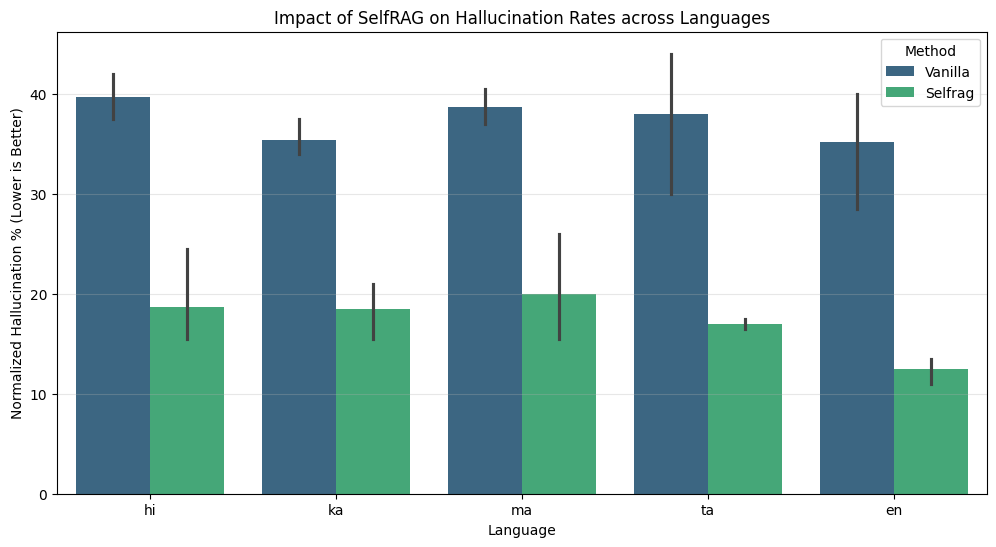

--- HYPOTHESIS 1: Is English better than Indic? ---

Method: Vanilla
Mean (En): 35.17% | Mean (Indic): 37.92%
P-Value: 0.2130 -> Not Significant

Method: Selfrag
Mean (En): 12.50% | Mean (Indic): 18.54%
P-Value: 0.0056 -> SIGNIFICANT

--- HYPOTHESIS 2: Does SelfRAG reduce Hallucinations? ---
Mean Drop: 20.03%
P-Value: 0.00032 -> SIGNIFICANT


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. Load Data
# Ensure your CSV file is in the current directory
df = pd.read_csv('hallucination_analysis_results_IndicQuest.csv')

# Select relevant columns
norm_cols = [
    'Model', 'Language',
    'Normalized_Hallucination_Percentage_Vanilla',
    'Normalized_Hallucination_Percentage_Selfrag'
]
df_analysis = df[norm_cols]

# --- PART A: VISUALIZATION ---

# Reshape data for plotting
df_long = pd.melt(
    df_analysis,
    id_vars=['Model', 'Language'],
    value_vars=['Normalized_Hallucination_Percentage_Vanilla', 'Normalized_Hallucination_Percentage_Selfrag'],
    var_name='Method',
    value_name='Hallucination_Percentage'
)
# Clean up labels
df_long['Method'] = df_long['Method'].str.replace('Normalized_Hallucination_Percentage_', '').str.capitalize()

# Plot: Vanilla vs SelfRAG by Language
plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x='Language', y='Hallucination_Percentage', hue='Method', palette='viridis')
plt.title('Impact of SelfRAG on Hallucination Rates across Languages')
plt.ylabel('Normalized Hallucination % (Lower is Better)')
plt.xlabel('Language')
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- PART B: STATISTICAL TESTING ---

# Define groups
indic_langs = [l for l in df['Language'].unique() if l != 'en']
en_data = df[df['Language'] == 'en']
indic_data = df[df['Language'].isin(indic_langs)]

print("--- HYPOTHESIS 1: Is English better than Indic? ---")
for method in ['Vanilla', 'Selfrag']:
    col = f'Normalized_Hallucination_Percentage_{method}'

    # Mann-Whitney U Test (Independent samples)
    stat, p_val = stats.mannwhitneyu(en_data[col], indic_data[col], alternative='less')

    print(f"\nMethod: {method}")
    print(f"Mean (En): {en_data[col].mean():.2f}% | Mean (Indic): {indic_data[col].mean():.2f}%")
    print(f"P-Value: {p_val:.4f} -> {'SIGNIFICANT' if p_val < 0.05 else 'Not Significant'}")

print("\n--- HYPOTHESIS 2: Does SelfRAG reduce Hallucinations? ---")
# Wilcoxon Signed-Rank Test (Paired samples)
col_vanilla = 'Normalized_Hallucination_Percentage_Vanilla'
col_selfrag = 'Normalized_Hallucination_Percentage_Selfrag'

stat, p_val = stats.wilcoxon(df[col_vanilla], df[col_selfrag], alternative='greater')

print(f"Mean Drop: {df[col_vanilla].mean() - df[col_selfrag].mean():.2f}%")
print(f"P-Value: {p_val:.5f} -> {'SIGNIFICANT' if p_val < 0.05 else 'Not Significant'}")

In [3]:
import shutil
import os

# Folder created by the visualization script
FOLDER_TO_SAVE = "viz_outputs"

# Name of the zip file to be created
ZIP_NAME = "viz_outputs_results"

# Remove existing zip if it already exists (avoids errors)
if os.path.exists(ZIP_NAME + ".zip"):
    os.remove(ZIP_NAME + ".zip")

# Create zip archive
shutil.make_archive(ZIP_NAME, 'zip', FOLDER_TO_SAVE)

print(f"Folder '{FOLDER_TO_SAVE}' has been saved as '{ZIP_NAME}.zip'")


Folder 'viz_outputs' has been saved as 'viz_outputs_results.zip'
